# 1. Import Libraries

In [1]:
import os, json, cv2
import numpy as np
import matplotlib.pyplot as plt 
import os.path as osp
import tempfile
import albumentations
import time

from lib.engine import train_one_epoch, evaluate

import torchvision
import torchvision.transforms as T
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image as Image, ImageDraw
from IPython.display import display

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
image_path = "/home/citiai-cygnus/Julius Thesis/Code/mmaction2/data/sop_dataset_rawframes_rgb/left_chest_hand/0700003/img_00003.jpg"

# 2. Initialization of Torch Dataset

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, annot_dir):
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]
        self.annotation_files = [f.replace('.jpg', '.json').replace('.png', '.json') for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        annotation_path = os.path.join(self.annot_dir, self.annotation_files[idx])
        with open(annotation_path, 'r') as f:
            annotation = json.load(f)
            
        annotations = annotation['annotations']
        
        bbox_data = annotations[0]['bbox']
        bboxes_original = [bbox_data]
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)     
        
        categories = annotations[0]['category_id']
        
        keypoints_data = annotations[0]['keypoints']
        reshaped_keypoints_data = [
            keypoints_data[i:i+3] for i in range(0, len(keypoints_data), 3)
        ]
        keypoints_original = [reshaped_keypoints_data]


        target = {
            'boxes':bboxes_original,
            'labels': torch.tensor([1], dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'area': (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0]),
            'iscrowd':  torch.zeros(len(bboxes_original), dtype=torch.int64),
            'keypoints': torch.as_tensor(keypoints_original, dtype=torch.float32),
            'category': torch.as_tensor(categories, dtype=torch.float32)
        }

        img = F.to_tensor(img)
        return img, target

    def collate_fn(self, batch):
        batch = [sample for sample in batch if sample is not None]
        return tuple(zip(*batch))

# 3. Initialization of Dataset and DataLoader

In [3]:
train_img_dir = "/home/citiai-cygnus/RollerDetection_HoangKhanh/roller_dataset_augmented/resized_train/images"
train_annot_dir = "/home/citiai-cygnus/RollerDetection_HoangKhanh/roller_dataset_augmented/resized_train/annotations"
test_img_dir = "/home/citiai-cygnus/RollerDetection_HoangKhanh/roller_dataset_augmented/resized_test/images"
test_annot_dir = "/home/citiai-cygnus/RollerDetection_HoangKhanh/roller_dataset_augmented/resized_test/annotations"

train_dataset = CustomDataset(train_img_dir, train_annot_dir)
test_dataset = CustomDataset(test_img_dir, test_annot_dir)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=test_dataset.collate_fn)

# 4. Definition of Model

In [4]:
model = keypointrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
num_keypoints = 1
model.roi_heads.keypoint_predictor = torchvision.models.detection.keypoint_rcnn.KeypointRCNNPredictor(
    in_channels=model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels,
    num_keypoints=num_keypoints
)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_channels=model.roi_heads.box_predictor.cls_score.in_features,
    num_classes=num_classes
)

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 50

/home/citiai-cygnus/anaconda3/envs/action/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/citiai-cygnus/anaconda3/envs/action/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 5. Model Training

In [5]:
for epoch in range(num_epochs):
    """
    model.train()
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets if t is not None]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {losses}")
    """
    # Below for accuracy logs
    
    start_time = time.time()
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=1000)
    lr_scheduler.step()
    # evaluate(model, test_loader, device)
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s')

print("Training finished")

Epoch: [0]  [   0/1345]  eta: 0:14:21  lr: 0.000002  loss: 8.9490 (8.9490)  loss_classifier: 0.7206 (0.7206)  loss_box_reg: 0.0350 (0.0350)  loss_keypoint: 8.0924 (8.0924)  loss_objectness: 0.0884 (0.0884)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 0.6408  data: 0.2075  max mem: 1976
Epoch: [0]  [1000/1345]  eta: 0:00:34  lr: 0.001000  loss: 4.6571 (5.9973)  loss_classifier: 0.0262 (0.1004)  loss_box_reg: 0.0754 (0.0936)  loss_keypoint: 4.5704 (5.7711)  loss_objectness: 0.0008 (0.0269)  loss_rpn_box_reg: 0.0027 (0.0052)  time: 0.1044  data: 0.0022  max mem: 2842
Epoch: [0]  [1344/1345]  eta: 0:00:00  lr: 0.001000  loss: 4.6647 (5.8339)  loss_classifier: 0.0203 (0.0810)  loss_box_reg: 0.0431 (0.0857)  loss_keypoint: 4.5612 (5.6421)  loss_objectness: 0.0004 (0.0206)  loss_rpn_box_reg: 0.0017 (0.0045)  time: 0.1024  data: 0.0022  max mem: 2842
Epoch: [0] Total time: 0:02:15 (0.1005 s / it)
Epoch 1/50, Time: 135.23s
Epoch: [1]  [   0/1345]  eta: 0:06:00  lr: 0.001000  loss: 5.8668 (5.8668) 

# 6. Initialization of Prediction Function

In [6]:
def predict_image(image_path, model, device):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.ToTensor(),
    ])
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    model.eval()

    with torch.no_grad():
        predictions = model(image_tensor)

    return predictions

# 7. Initialization of Visualization Prediction Function

In [32]:
def visualize_predictions(image_path, json_path, pred, figsize=(10, 10), keypoint_color="red", bbox_color="red", truth_color="yellow"):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    
    # Draw ground truth annotations
    if json_path:
        with open(json_path, 'r') as f:
            truth_json = json.load(f)
        
        for annotation in truth_json["annotations"]:
            if 'bbox' in annotation and 'keypoints' in annotation:
                bbox = annotation['bbox']
                keypoints = annotation['keypoints']
                    
                # Draw bounding box
                draw.rectangle([int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])], outline=truth_color, width=2)
                    
                # Draw keypoints
                for i in range(0, len(keypoints), 3):
                    x_truth = int(keypoints[i])
                    y_truth = int(keypoints[i+1])
                    draw.ellipse([x_truth-2, y_truth-2, x_truth+2, y_truth+2], fill=truth_color)
    
    # Get predicted bbox
    highest_score_idx = torch.argmax(pred['scores'])
    
    highest_score_box = pred['boxes'][highest_score_idx]
    highest_score_keypoints = pred['keypoints'][highest_score_idx]
    highest_score_keypoints_scores = pred['keypoints_scores'][highest_score_idx]
    
    # Draw predicted bbox
    xmin, ymin, xmax, ymax = highest_score_box
    print(highest_score_box)
    draw.rectangle([xmin, ymin, xmax, ymax], outline=bbox_color, width=2)
    
    # Get predicted keypoint
    highest_kpt_score_idx = torch.argmax(highest_score_keypoints_scores)
    highest_score_kpt = highest_score_keypoints[highest_kpt_score_idx]
    
    # Draw predicted keypoint
    x, y, visibility = highest_score_kpt
    print(highest_score_kpt)
    draw.ellipse([x-2, y-2, x+2, y+2], fill=keypoint_color)
    
    # Show the visualization image
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# 8. Running Inference on Test Dataset

tensor([319.1958, 199.5829, 344.1985, 211.6165], device='cuda:0')
tensor([331.6971, 204.9055,   1.0000], device='cuda:0')


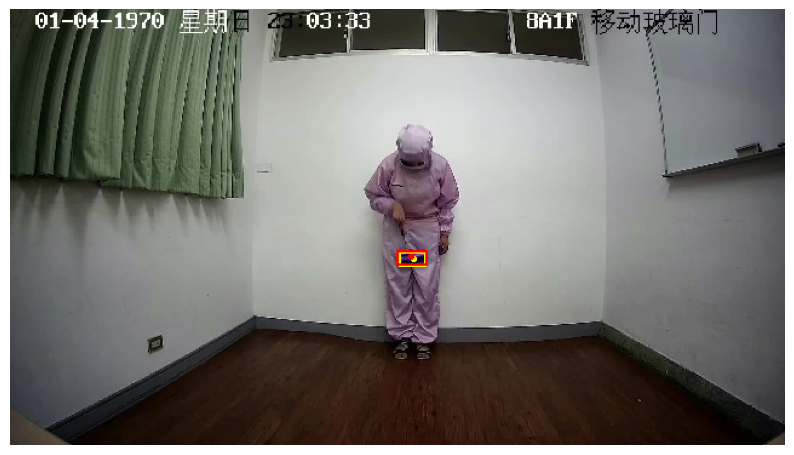

In [20]:
test_id = "0100006_000001"
image_path = "/home/citiai-cygnus/RollerDetection_HoangKhanh/roller_dataset_augmented/resized_test/images/{}_resize_augmented.jpg".format(test_id)
json_path = "/home/citiai-cygnus/RollerDetection_HoangKhanh/roller_dataset_augmented/resized_test/annotations/{}_resize_augmented.json".format(test_id)
predictions = predict_image(image_path, model, device)
pred = predictions[0]
visualize_predictions(image_path, json_path, pred)

Evaluate the accuracy of the model:

In [9]:
evaluate(model, train_loader, device)

creating index...
index created!
Test:  [   0/1345]  eta: 0:03:45  model_time: 0.0405 (0.0405)  evaluator_time: 0.0000 (0.0000)  time: 0.1673  data: 0.1224  max mem: 2844
Test:  [ 100/1345]  eta: 0:00:54  model_time: 0.0372 (0.0373)  evaluator_time: 0.0000 (0.0000)  time: 0.0427  data: 0.0020  max mem: 2844
Test:  [ 200/1345]  eta: 0:00:49  model_time: 0.0367 (0.0371)  evaluator_time: 0.0000 (0.0000)  time: 0.0421  data: 0.0020  max mem: 2844
Test:  [ 300/1345]  eta: 0:00:44  model_time: 0.0365 (0.0370)  evaluator_time: 0.0000 (0.0000)  time: 0.0461  data: 0.0061  max mem: 2844
Test:  [ 400/1345]  eta: 0:00:40  model_time: 0.0365 (0.0370)  evaluator_time: 0.0000 (0.0000)  time: 0.0417  data: 0.0019  max mem: 2844
Test:  [ 500/1345]  eta: 0:00:36  model_time: 0.0367 (0.0370)  evaluator_time: 0.0000 (0.0000)  time: 0.0420  data: 0.0019  max mem: 2844
Test:  [ 600/1345]  eta: 0:00:31  model_time: 0.0367 (0.0370)  evaluator_time: 0.0000 (0.0000)  time: 0.0420  data: 0.0019  max mem: 2844
T

In [10]:
evaluate(model, test_loader, device)

creating index...
index created!
Test:  [  0/129]  eta: 0:00:20  model_time: 0.0394 (0.0394)  evaluator_time: 0.0000 (0.0000)  time: 0.1611  data: 0.1081  max mem: 2844
Test:  [100/129]  eta: 0:00:01  model_time: 0.0367 (0.0371)  evaluator_time: 0.0000 (0.0000)  time: 0.0413  data: 0.0019  max mem: 2844
Test:  [128/129]  eta: 0:00:00  model_time: 0.0369 (0.0370)  evaluator_time: 0.0000 (0.0000)  time: 0.0415  data: 0.0019  max mem: 2844
Test: Total time: 0:00:05 (0.0429 s / it)
Averaged stats: model_time: 0.0369 (0.0370)  evaluator_time: 0.0000 (0.0000)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.633
 

# 9. Save Model

In [11]:
model_save_path = "result/keypoint_rcnn_model_roller_detection.pth"
torch.save(model, model_save_path)
print(f"Entire model saved to {model_save_path}")

Entire model saved to result/keypoint_rcnn_model_roller_detection.pth


# 10. Load Roller Detector Model

In [12]:
model_path = "/home/citiai-cygnus/RollerDetection_HoangKhanh/result/keypoint_rcnn_model_roller_detection.pth"
model_loaded = torch.load(model_path, map_location=device)
model_loaded.to(device)
model_loaded.eval()
print("Entire model loaded and ready for inference.")

Entire model loaded and ready for inference.


# 11. Inference Roller Detector Model

tensor([319.1958, 199.5829, 344.1985, 211.6165], device='cuda:0')
tensor([331.6971, 204.9055,   1.0000], device='cuda:0')


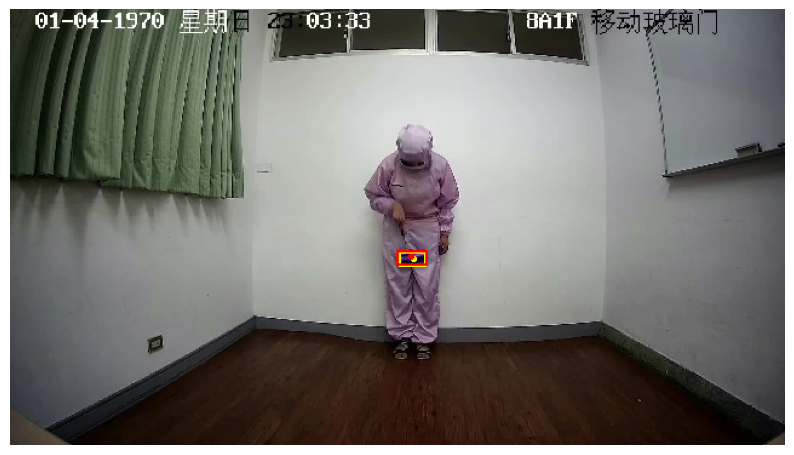

In [21]:
predictions = predict_image(image_path, model_loaded, device)
pred = predictions[0]
visualize_predictions(image_path, json_path, pred)

In [ ]:
predictions

In [ ]:
pred

In [30]:
def save_visualization_predicted(test_dir, save_path):
    # Define the colors for use
    truth_color = (255, 255, 0)
    predict_color = (255, 0, 0)
    
    # Define the image and ground truth annotation directories
    img_dir = os.path.join(test_dir, 'images/')
    json_dir = os.path.join(test_dir, 'annotations/')
    
    # Iterate through all json files in the directory
    for json_file in os.listdir(json_dir):
        # Load and read truth annotation json file
        json_path = os.path.join(json_dir, json_file)
        with open(json_path, 'r') as f:
            truth_annotation = json.load(f)
            
        # Load image
        img_file = json_file[:-5] + '.jpg'
        img_path = os.path.join(img_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert color
        
        # Draw ground truth annotation
        for annotation in truth_annotation['annotations']:
            truth_bbox = annotation['bbox']
            truth_kpt = annotation['keypoints']
            
            # Draw ground truth bbox
            cv2.rectangle(image, (int(truth_bbox[0]), int(truth_bbox[1])), (int(truth_bbox[2]), int(truth_bbox[3])), truth_color, 1)
            
            # Draw ground truth keypoint
            truth_x = int(truth_kpt[0])
            truth_y = int(truth_kpt[1])
            cv2.circle(image, (truth_x, truth_y), 1, truth_color, -1)
            
        # Get predicted result
        predictions = predict_image(img_path, model_loaded, device)
        pred = predictions[0]    
        
        # Draw predicted annotations
        # Get predicted bbox
        highest_score_idx = torch.argmax(pred['scores'])
    
        highest_score_box = pred['boxes'][highest_score_idx]
        highest_score_keypoints = pred['keypoints'][highest_score_idx]
        highest_score_keypoints_scores = pred['keypoints_scores'][highest_score_idx]
    
        # Draw predicted bbox
        xmin, ymin, xmax, ymax = highest_score_box
        cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), predict_color, 1)
    
        # Get predicted keypoint
        highest_kpt_score_idx = torch.argmax(highest_score_keypoints_scores)
        highest_score_kpt = highest_score_keypoints[highest_kpt_score_idx]
    
        # Draw predicted keypoint
        predict_x, predict_y, visibility = highest_score_kpt
        cv2.circle(image, (int(predict_x), int(predict_y)), 1, predict_color, -1)
        
        # Save image
        output_image_path = os.path.join(save_path, img_file)
        cv2.imwrite(output_image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        print(f'Saved annotated image: {output_image_path}')
        
    print("Saved everything successfully!")

In [31]:
test_dir = "/home/citiai-cygnus/RollerDetection_HoangKhanh/roller_dataset_augmented/resized_test"
save_path = "/home/citiai-cygnus/RollerDetection_HoangKhanh/result/resized_test"
save_visualization_predicted(test_dir, save_path)

Saved annotated image: /home/citiai-cygnus/RollerDetection_HoangKhanh/result/resized_test/0400091_000002_resize_augmented.jpg
Saved annotated image: /home/citiai-cygnus/RollerDetection_HoangKhanh/result/resized_test/0400042_000002_resize_augmented.jpg
Saved annotated image: /home/citiai-cygnus/RollerDetection_HoangKhanh/result/resized_test/0200108_000003_resize_augmented.jpg
Saved annotated image: /home/citiai-cygnus/RollerDetection_HoangKhanh/result/resized_test/0500092_000003_resize_augmented.jpg
Saved annotated image: /home/citiai-cygnus/RollerDetection_HoangKhanh/result/resized_test/0100059_000003_resize_augmented.jpg
Saved annotated image: /home/citiai-cygnus/RollerDetection_HoangKhanh/result/resized_test/0500109_000001_resize_augmented.jpg
Saved annotated image: /home/citiai-cygnus/RollerDetection_HoangKhanh/result/resized_test/0100073_000002_resize_augmented.jpg
Saved annotated image: /home/citiai-cygnus/RollerDetection_HoangKhanh/result/resized_test/0500043_000004_resize_augmen

tensor([199.0364, 121.2581, 211.8572, 154.2513], device='cuda:0')
tensor([205.4468, 137.7547,   1.0000], device='cuda:0')


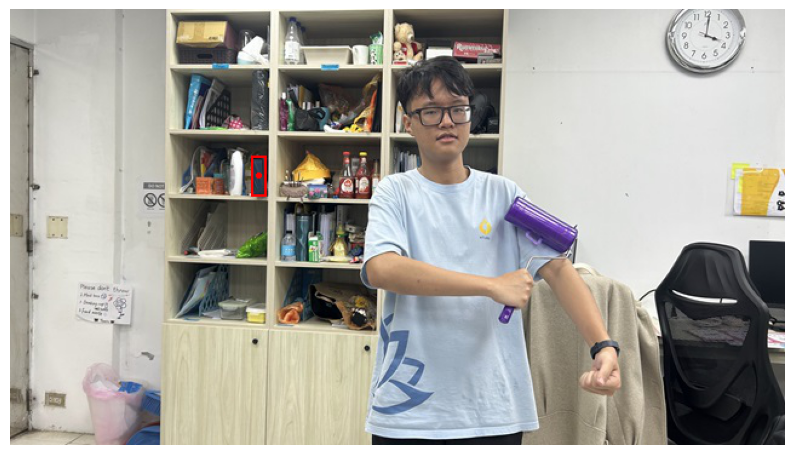

In [33]:
self_test_path = "/home/citiai-cygnus/RollerDetection_HoangKhanh/nhk_test.jpg"
self_prediction = predict_image(self_test_path, model_loaded, device)
self_pred = self_prediction[0]
visualize_predictions(self_test_path, None, self_pred)

# 12. Inference Pose with MMPose Model

In [ ]:
import cv2
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector

In [ ]:
pose_config = '/home/citiai-cygnus/Julius Thesis/Code/mmaction2/demo/hrnet_w32_coco_256x192.py'
pose_checkpoint = '/home/citiai-cygnus/Julius Thesis/Code/mmaction2/data/hrnet_w32_coco_256x192-c78dce93_20200708.pth'
det_config = '/home/citiai-cygnus/Julius Thesis/Code/mmaction2/data/faster_rcnn_r50_fpn_2x_coco.py'
det_checkpoint = '/home/citiai-cygnus/Julius Thesis/Code/mmaction2/data/faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth'

pose_model = init_pose_model(pose_config, pose_checkpoint)
det_model = init_detector(det_config, det_checkpoint)

mmdet_results = inference_detector(det_model, image_path)
person_results = process_mmdet_results(mmdet_results, cat_id=1)

pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    image_path,
    person_results,
    bbox_thr=0.3,
    format='xyxy',
    dataset=pose_model.cfg.data.test.type)

vis_result = vis_pose_result(
    pose_model,
    image_path,
    pose_results,
    dataset=pose_model.cfg.data.test.type,
    show=False)

In [ ]:

with tempfile.TemporaryDirectory() as tmpdir:
    file_name = osp.join(tmpdir, 'pose_results.png')
    cv2.imwrite(file_name, vis_result)
    pil_image = Image.open(file_name)
    display(pil_image)

In [ ]:
pose_results

# 13. Visualization Inference Roller and Pose Estimation

In [ ]:
def display_result(vis_result, pred):
    with tempfile.TemporaryDirectory() as tmpdir:
        figsize = (10, 10)
        keypoint_color = "yellow"
        bbox_color = "red"
        
        file_name = osp.join(tmpdir, 'pose_results.png')
        cv2.imwrite(file_name, vis_result)
        
        image = Image.open(file_name).convert("RGB")
        draw = ImageDraw.Draw(image)
        
        highest_score_idx = torch.argmax(pred['scores'])
        highest_score_box = pred['boxes'][highest_score_idx]
        highest_score_keypoints = pred['keypoints'][highest_score_idx]
        highest_score_keypoints_scores = pred['keypoints_scores'][highest_score_idx]
        
        xmin, ymin, xmax, ymax = highest_score_box
        draw.rectangle([xmin, ymin, xmax, ymax], outline=bbox_color, width=2)
        
        highest_kpt_score_idx = torch.argmax(highest_score_keypoints_scores)
        highest_score_kpt = highest_score_keypoints[highest_kpt_score_idx]
        
        x, y, visibility = highest_score_kpt
        draw.ellipse([x-3, y-3, x+3, y+3], fill=keypoint_color)
        
        updated_file_name = osp.join(tmpdir, 'updated_pose_results.png')
        image.save(updated_file_name)
        pil_image = Image.open(updated_file_name)
        display(pil_image)

In [ ]:
display_result(vis_result, pred)

# 14. Action Completion Recognition

In [ ]:
keypoints = pose_results[0]['keypoints']
keypoint_coords = keypoints[:, :2]

left_shoulder_idx = 5
left_elbow_idx = 7
left_wrist_idx = 9

left_shoulder = keypoint_coords[left_shoulder_idx]
left_elbow = keypoint_coords[left_elbow_idx]
left_wrist = keypoint_coords[left_wrist_idx]

print('Keypoint Left Shoulder:', left_shoulder)
print('Keypoint Left Elbow:', left_elbow)
print('Keypoint Left Wrist:', left_wrist)

In [ ]:
keypoints_tensor = predictions[0]['keypoints']
keypoints_np = keypoints_tensor.cpu().numpy()
x = keypoints_np[0, 0, 0]  # x coordinate
y = keypoints_np[0, 0, 1]  # y coordinate

print('Keypoint Roller x:', x)
print('Keypoint Roller y:', y)

# 15. Initialization of Distance Calculation using Perpendicular Distance (Line & Point)

In [ ]:
import math
import sympy as sp
from sympy import Line as Line, Point

def coefficient_linear_equation(first_keypoint, second_keypoint):
    x,y = sp.symbols('x y')
    line_eq = Line(Point(first_keypoint[0], first_keypoint[1]), Point(second_keypoint[0], second_keypoint[1]))
    A, B, C = line_eq.coefficients
    return A, B, -C

def perpendicular_distance_from_point_to_line(roller_keypoint, A, B, C):
    x0, y0 = roller_keypoint
    distance = abs(A * x0 + B * y0 + C) / math.sqrt(A**2 + B**2)
    return distance


# 16. Initialization of Distance Calculation using Euclidean Distance (Point & Point)

In [ ]:
def euclidean_distance(keypoint, roller_keypoint):
    x1, y1 = keypoint
    x2, y2 = roller_keypoint
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# 17. Distance Calculation using Line to Point

In [ ]:
roller_keypoint = (x, y)

coeff_X, coeff_Y, constanta = coefficient_linear_equation(left_elbow,left_shoulder)
coeff_X_1, coeff_Y_1, constanta_1 = coefficient_linear_equation(left_elbow,left_wrist)
coeff_X_2, coeff_Y_2, constanta_2 = coefficient_linear_equation(left_wrist,left_shoulder)

distance_elbow_shoulder = perpendicular_distance_from_point_to_line(roller_keypoint, coeff_X, coeff_Y, constanta)
distance_elbow_wrist = perpendicular_distance_from_point_to_line(roller_keypoint, coeff_X_1, coeff_Y_1, constanta_1)
distance_wrist_shoulder = perpendicular_distance_from_point_to_line(roller_keypoint, coeff_X_2, coeff_Y_2, constanta_2)

print ("Elbow-Shoulder Limb -> roller keypoint : ", distance_elbow_shoulder)
print ("Elbow-Wrist Limb -> roller keypoint : ", distance_elbow_wrist)
print ("Wrist-Shoulder Limb -> roller keypoint : ", distance_wrist_shoulder)

# 18. Distance Calculation using Point to Point

In [ ]:
distance_euclidean_elbow = euclidean_distance(left_elbow, roller_keypoint)
distance_euclidean_shoulder = euclidean_distance(left_shoulder, roller_keypoint)
distance_euclidean_wrist = euclidean_distance(left_wrist, roller_keypoint)
print ("Elbow keypoint -> roller keypoint : ", distance_euclidean_elbow)
print ("Shoulder keypoint -> roller keypoint : ", distance_euclidean_shoulder)
print ("Wrist keypoint -> roller keypoint : ", distance_euclidean_wrist)

# 19. Display Body Dataset Completion

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the JSON annotation
with open('/home/citiai-cygnus/Downloads/sop_dataset_coco/0100001_000001 (1).json', 'r') as f:
    annotation = json.load(f)

# Load the image
image_path = '/home/citiai-cygnus/Downloads/sop_dataset_coco/0100001_000001 (1).jpg'
image = Image.open(image_path)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Display the image
ax.imshow(image)

# Extract annotation information
bbox = annotation['annotations'][0]['bbox']
keypoints = annotation['annotations'][0]['keypoints']

# Draw bounding box
x, y, w, h = bbox
rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

keypoint_colors = ['#75e384', '#75e384', '#75e384']  # Color for each keypoint

for i in range(0, len(keypoints), 3):
    x, y, visibility = keypoints[i:i+3]
    color = keypoint_colors[visibility]
    ax.plot(x, y, marker='o', markersize=5, color=color)

plt.tight_layout()
plt.show()
